In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Ruta de la carpeta de imágenes y del CSV
image_dir = '/content/drive/My Drive/Proyecto-DataSets/imagenes_claras'
csv_file = '/content/drive/My Drive/Proyecto-DataSets/dataset_clean.csv'

# Cargar el CSV
df = pd.read_csv(csv_file)

# Asegurar que las etiquetas estén separadas por comas para imágenes con múltiples ingredientes
df['label'] = df['label'].apply(lambda x: x.split(','))

# Verificar la existencia de cada imagen
valid_images = []
valid_labels = []
for i, row in df.iterrows():
    image_path = os.path.join(image_dir, row['image'])
    if os.path.exists(image_path) and os.path.getsize(image_path) > 0:  # Verifica si la imagen existe y no está vacía, tuve que hacer esto xq habia un par de fotos rotas.
        valid_images.append(row['image'])
        valid_labels.append(row['label'])

# el nuevo dataset seria
df_valid = pd.DataFrame({
    'image': valid_images,
    'label': valid_labels
})

# Multi-label obviamente muchas etiquetas en distintas imagenes.
# One-Hot Encoding: prende o apaga el bit para decir que esta tal ingrediente en la imagen o no.
mlb = MultiLabelBinarizer()
df_valid['one_hot_label'] = mlb.fit_transform(df_valid['label']).tolist() # aca hace la transormacion de las etiquetas a vectores binarios (0,1,0,0,1) asi

# Mostrar las clases que se generaron
print("Clases: ", mlb.classes_)

# Crear un DataFrame para almacenar las etiquetas one-hot
one_hot_labels = pd.DataFrame(df_valid['one_hot_label'].to_list(), columns=mlb.classes_)

# Crear un DataFrame final que contenga las rutas de las imágenes y sus etiquetas one-hot
df_final = pd.concat([df_valid['image'], one_hot_labels], axis=1)

# Guardar el CSV limpio con las etiquetas codificadas y las imágenes válidas
clean_csv_path = '/content/drive/My Drive/Proyecto-DataSets/dataset_clean_one_hot.csv'
df_final.to_csv(clean_csv_path, index=False)

print(f"CSV con etiquetas one-hot y imágenes válidas generado en: {clean_csv_path}")


Clases:  [' aceituna negra' ' ajo' ' ananá' ' arándano' ' banana' ' cebolla'
 ' cebolla de verdeo' ' cebolla morada' ' cereza' ' chile amarillo'
 ' chile verde' ' durazno' ' frambuesa' ' frutilla' ' granada' ' kiwi'
 ' lima' ' limón' ' mandarina' ' mango' ' manzana verde' ' naranja'
 ' palta' ' pimiento amarillo' ' pimiento rojo' ' pimiento verde'
 ' pomelo' ' rabanito' ' sandía' ' tomate' ' tomate cherry' ' uva blanca'
 ' uva rosada' ' zanahoria' 'aceituna' 'aceituna negra' 'ajo' 'ananá'
 'anquito' 'apio' 'arroz' 'arveja' 'arándano' 'banana' 'batata'
 'berenjena' 'brocoli' 'cebolla' 'cebolla de verdeo' 'cebolla morada'
 'cereza' 'chile amarillo' 'chile rojo' 'chile verde' 'choclo' 'ciruela'
 'ciruela amarilla' 'coco' 'coliflor' 'durazno' 'espinaca' 'espárrago'
 'fideo' 'frambuesa' 'frutilla' 'granada' 'higo' 'huevo'
 'imagenes_claras/imagen_3600.jpg' 'jengibre' 'kiwi' 'lechuga' 'lenteja'
 'lima' 'limón' 'mandarina' 'mango' 'manzana' 'manzana verde' 'maní'
 'mora' 'naranja' 'palta' 'pa

In [58]:
from sklearn.utils import class_weight
import tensorflow as tf

# Crear el generador de imágenes
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles
    validation_split=0.2  # 80% para entrenamiento, 20% para validación
)

# Dataset de entrenamiento
train_dataset = datagen.flow_from_dataframe(
    dataframe=df_final,
    directory=image_dir,
    x_col="image",  # Columna con las imágenes
    y_col=mlb.classes_.tolist(),  # cada imagen esta asociada con las etiquetas correctas
    target_size=(224, 224),  # Ajustar tamaño de imagen
    batch_size=32,
    class_mode="raw",  # Usar etiquetas en crudo (vectores one-hot)
    subset="training",  # Parte del conjunto para entrenamiento
    shuffle=True
)

# Dataset de validación
validation_dataset = datagen.flow_from_dataframe(
    dataframe=df_final,
    directory=image_dir,
    x_col="image",
    y_col=mlb.classes_.tolist(),
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    subset="validation"  # Parte del conjunto para validación
)

# Crear un diccionario de pesos de clase (esto es importante para el balanceo)
class_labels = df['label'].apply(lambda x: ','.join(x)).values  # Unir las etiquetas de nuevo para calcular los pesos de clase
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

Found 2077 validated image filenames.
Found 519 validated image filenames.


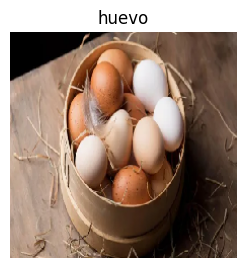

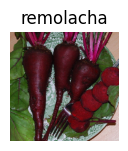

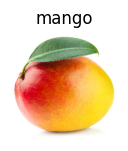

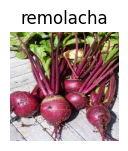

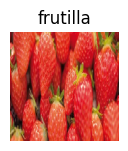

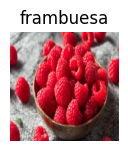

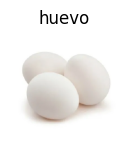

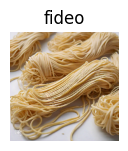

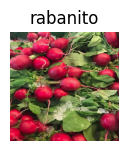

In [59]:
import matplotlib.pyplot as plt

class_indices = {i: label for i, label in enumerate(mlb.classes_)}  # Crear diccionario de índices de clase , para ver las etiquetas con la imagen bien.

image, label = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title(', '.join([class_indices[j] for j in range(len(label[i])) if label[i][j] > 0]))
    plt.axis("off")
    plt.show()



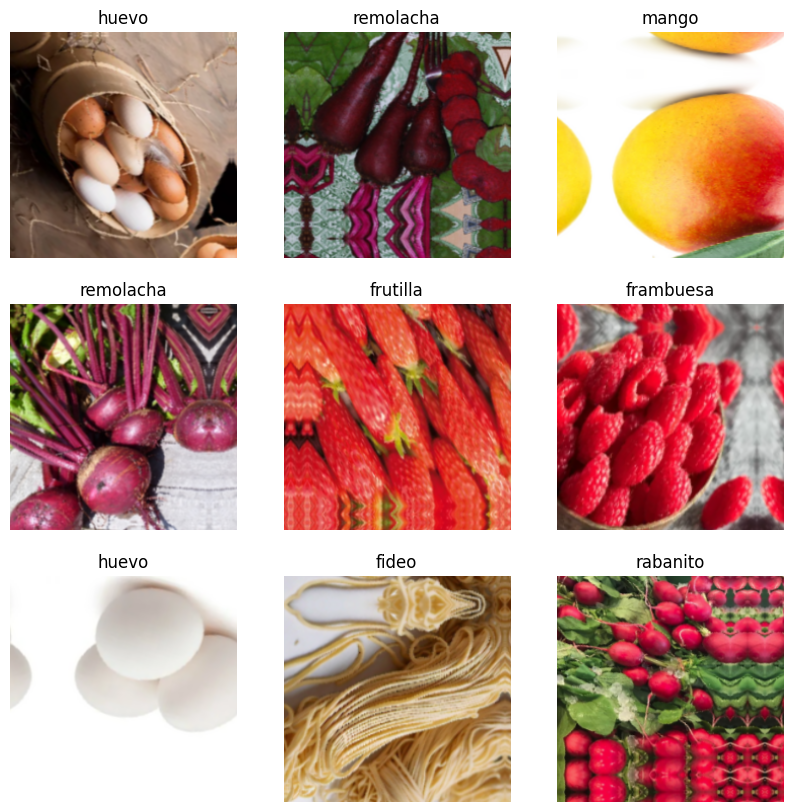

In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

data_augmentation = Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(image)
    plt.imshow(augmented_image[i])
    plt.title(', '.join([class_indices[j] for j in range(len(label[i])) if label[i][j] > 0]))
    plt.axis("off")


In [61]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # sin la capa final(top) para solo extraer caracteristicas de las fotos

# esto es para prevenir el sobreajuste yo congelo todas las capas de mobilenet y solo extraigo lo que me sirve de mobile net
# que es el reconocimiento de imagenes, no ir cambiando los pesos durante el entrenamiento.
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    data_augmentation,
    base_model, # aca estaria todo lo que es filtrado y agrupamiento (Conv2d y MaxPooling2d)
    # luego del modelo base, hago yo nuevas capas de entrenamiento para mi problema particular.
    # procesamiento de las imagenes y clasificacion.

    tf.keras.layers.GlobalAveragePooling2D(),  # como flatten pero va agarrando lo que va aprendiendo para mejorar el entrenamiento , si usamos mobileNet esta bueno usarlo para tratar de no tener sobre ajuste
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Activación sigmoid para multietiqueta]
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# un resumen si se quiere
# model.summary()

# Early stopping si fuera necesario
#early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# ir agarrando el mejor modelo a medida que pase el entrenamiento
#checkpoint = ModelCheckpoint(
#    '/content/drive/My Drive/Proyecto-DataSets/mejorModelo.keras',
#   monitor='val_loss',
#    save_best_only=True
#)

In [62]:
# Obtener un lote de imágenes
images, labels = next(train_dataset)  # next() obtiene el siguiente lote del iterador

# Verificar las dimensiones del lote
print(f"Dimensiones de las imágenes: {images.shape}")  # Debe ser algo como (batch_size, 224, 224, 3)
print(f"Dimensiones de las etiquetas: {labels.shape}")

Dimensiones de las imágenes: (32, 224, 224, 3)
Dimensiones de las etiquetas: (32, 104)


In [65]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // validation_dataset.batch_size,
    epochs=40,
    class_weight=class_weight_dict,
    #callbacks=[early_stopping, checkpoint]
)

Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 645ms/step - accuracy: 0.3465 - loss: 0.2497 - val_accuracy: 0.0410 - val_loss: 0.0749
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2812 - loss: 0.3216 - val_accuracy: 0.1429 - val_loss: 0.0716
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 615ms/step - accuracy: 0.3727 - loss: 0.1947 - val_accuracy: 0.0430 - val_loss: 0.0750
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 0.1439 - val_accuracy: 0.0000e+00 - val_loss: 0.0711
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 648ms/step - accuracy: 0.4045 - loss: 0.1790 - val_accuracy: 0.0430 - val_loss: 0.0769
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.4688 - loss: 0.1361 - val_accuracy: 0.0000e+00 - val_loss: 0.0786
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 651ms/step - accuracy: 0.4111 - loss: 0.1538 - val_accuracy: 0.0430 - val_loss: 0.0793
Epoch 8/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.3125 - loss: 0.1832 - val_acc

In [70]:
loss, accuracy = model.evaluate(train_dataset)
print(f"Pérdida en entrenamiento: {loss}")
print(f"Precisión en entrenamiento: {accuracy}")
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Pérdida en validación: {val_loss}")
print(f"Precisión en validación: {val_accuracy}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 517ms/step - accuracy: 0.5854 - loss: 0.0275
Pérdida en entrenamiento: 0.02780677191913128
Precisión en entrenamiento: 0.5878671407699585
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - accuracy: 0.0494 - loss: 0.0841
Pérdida en validación: 0.08309423923492432
Precisión en validación: 0.04238921031355858


In [71]:
model_save_path = '/content/drive/My Drive/Proyecto-DataSets/modeloEntrenado.keras'
model.save(model_save_path)